In [1]:
import numpy as np
import pickle

# 加载数据
with open('R_ET_1_ET_2_ET_3_0.pkl', 'rb') as file:
    data = pickle.load(file)
print(data)

# 提取9x9的 Fisher 矩阵
fisher_matrix_1 = data[1]
fisher_matrix_2 = data[2][0]
fisher_matrix_3 = data[2][1]

[array([3.16941035, 6.9962458 , 4.00835021]), array([[ 7.59422727e+03, -6.25421725e+03,  6.23751171e+05,
        -1.34338454e+02,  8.66625938e+01, -2.32456024e+06,
         1.33984732e+02, -2.20557589e+06, -5.33260719e+02],
       [-6.25421725e+03,  5.87158926e+03, -5.36364805e+05,
         1.21212590e+02, -5.60438178e+02,  2.57788444e+06,
        -1.09244274e+02,  2.47757514e+06,  4.86961137e+02],
       [ 6.23751171e+05, -5.36364805e+05,  5.22755622e+07,
         1.28894420e-01,  2.37668170e+04, -2.17646497e+08,
         9.43542955e+03, -2.07722407e+08, -4.58809748e+04],
       [-1.34338454e+02,  1.21212590e+02,  1.28894420e-01,
         3.97957676e+02,  3.52978924e+01, -2.14112298e+02,
        -6.82600789e+01, -2.42386238e+02,  1.15709219e-02],
       [ 8.66625938e+01, -5.60438178e+02,  2.37668170e+04,
         3.52978924e+01,  3.37913515e+02, -4.65927864e+05,
         1.88476820e+00, -4.62697347e+05, -3.88440801e+01],
       [-2.32456024e+06,  2.57788444e+06, -2.17646497e+08,
     

In [2]:
# 动态正则化项函数
def get_dynamic_epsilon(matrix):
    cond_number = np.linalg.cond(matrix)
    eigvals = np.linalg.eigvals(matrix)
    eigval_std = np.std(eigvals)
    
    if cond_number > 1e20 or eigval_std > 1e2:
        return 1e-2
    elif cond_number > 1e16 or eigval_std > 1e1:
        return 1e-3
    elif cond_number > 1e12:
        return 1e-4
    else:
        return 1e-6

# 强化特征值裁剪，确保特征值在更严格的范围内
def ensure_positive_definite(matrix, matrix_name=""):
    eigvals, eigvecs = np.linalg.eigh(matrix)
    
    # 打印特征值供调试
    print(f"{matrix_name} Eigenvalues before clipping: {eigvals}")
    
    # 将特征值限制在 [1e-2, 1e3] 之间，避免极端特征值
    eigvals_clipped = np.clip(eigvals, 1e-2, 1e3)
    
    # 打印裁剪后的特征值
    print(f"{matrix_name} Eigenvalues after clipping: {eigvals_clipped}")
    
    # 重构正定矩阵
    matrix_pos_def = eigvecs @ np.diag(eigvals_clipped) @ eigvecs.T
    return matrix_pos_def

# 正则化矩阵
def regularize_matrix(matrix, matrix_name=""):
    epsilon = get_dynamic_epsilon(matrix)
    
    # 打印条件数供调试
    cond_number = np.linalg.cond(matrix)
    if cond_number > 1e12:
        print(f"Matrix condition number is high ({cond_number}), adding regularization with epsilon {epsilon}.")
    
    # 确保矩阵对称性
    matrix_sym = (matrix + matrix.T) / 2
    return ensure_positive_definite(matrix_sym + epsilon * np.eye(matrix.shape[0]), matrix_name)

In [3]:
# 计算协方差矩阵
def compute_covariance(fisher_matrix, matrix_name=""):
    reg_matrix = regularize_matrix(fisher_matrix, matrix_name)
    cov_matrix = np.linalg.pinv(reg_matrix)
    return cov_matrix

cov_matrix_1 = compute_covariance(fisher_matrix_1, "matrix_1")
cov_matrix_2 = compute_covariance(fisher_matrix_2, "matrix_2")
cov_matrix_3 = compute_covariance(fisher_matrix_3, "matrix_3")

# 打印验证
print("Shape of fisher_matrix_1:", fisher_matrix_1.shape)
print("Shape of cov_matrix_1:", cov_matrix_1.shape)

Matrix condition number is high (48861618152123.75), adding regularization with epsilon 0.01.
matrix_1 Eigenvalues before clipping: [1.09525817e-02 5.98675635e-02 5.03005838e-01 3.00063851e+02
 5.11861407e+02 7.39108438e+02 1.85114764e+06 5.18867547e+07
 4.66563539e+10]
matrix_1 Eigenvalues after clipping: [1.09525817e-02 5.98675635e-02 5.03005838e-01 3.00063851e+02
 5.11861407e+02 7.39108438e+02 1.00000000e+03 1.00000000e+03
 1.00000000e+03]
Matrix condition number is high (2.2272967104875676e+20), adding regularization with epsilon 0.01.
matrix_2 Eigenvalues before clipping: [1.00002502e-02 1.00034416e-02 1.09056862e-02 5.68898891e+01
 9.64039835e+01 1.04282695e+02 1.40763718e+02 1.11061715e+05
 3.67349128e+10]
matrix_2 Eigenvalues after clipping: [1.00002502e-02 1.00034416e-02 1.09056862e-02 5.68898891e+01
 9.64039835e+01 1.04282695e+02 1.40763718e+02 1.00000000e+03
 1.00000000e+03]
Matrix condition number is high (48861618152123.75), adding regularization with epsilon 0.01.
matrix_

In [4]:
# 优化均值计算
mean1 = np.mean(cov_matrix_1, axis=0)
mean2 = np.mean(cov_matrix_2, axis=0)
mean3 = np.mean(cov_matrix_3, axis=0)

# 动态调节 KL 散度中的 Trace 和均值差项
def dynamic_clip(value, threshold=250):
    """动态限制数值的最大值"""
    return min(value, threshold)

def kl_divergence(cov1, mean1, cov2, mean2, matrix_name=""):
    """
    计算两个多元高斯分布之间的KL散度
    """
    # 正定化矩阵
    cov2_regularized = regularize_matrix(cov2, matrix_name)
    
    # 检查特征值
    eigvals_cov2 = np.linalg.eigvals(cov2_regularized)
    if np.any(eigvals_cov2 <= 0):
        print(f"Matrix {matrix_name} has non-positive eigenvalues, skipping KL computation.")
        return np.nan
    
    # 使用标准逆矩阵
    try:
        inv_cov2 = np.linalg.inv(cov2_regularized)
    except np.linalg.LinAlgError:
        print(f"Matrix {matrix_name} inversion failed, skipping KL computation.")
        return np.nan
    
    # 计算 Trace 项
    term1 = np.trace(inv_cov2 @ cov1)
    term1 = dynamic_clip(term1, 250)  # 限制 Trace 项
    print(f"{matrix_name} KL term1 (Trace): {term1}")
    
    # 计算行列式对数差
    sign1, logdet1 = np.linalg.slogdet(cov1)
    sign2, logdet2 = np.linalg.slogdet(cov2_regularized)
    
    if sign1 <= 0 or sign2 <= 0:
        print(f"Matrix {matrix_name} determinant is non-positive.")
        return np.nan
    
    term2 = logdet2 - logdet1
    print(f"{matrix_name} KL term2 (Log determinant difference): {term2}")
    
    # 计算均值差项
    term3 = (mean2 - mean1).T @ inv_cov2 @ (mean2 - mean1)
    term3 = dynamic_clip(term3, 250)  # 限制均值差项
    print(f"{matrix_name} KL term3 (Mean difference): {term3}")
    
    # 计算 KL 散度
    result = 0.5 * (term1 + term2 + term3 - cov1.shape[0])
    print(f"{matrix_name} KL result: {result}")
    
    return max(result, 0)

# 计算并输出每两个矩阵之间的KL散度
kl_12 = kl_divergence(cov_matrix_1, mean1, cov_matrix_2, mean2, "matrix_12")
kl_13 = kl_divergence(cov_matrix_1, mean1, cov_matrix_3, mean3, "matrix_13")
kl_23 = kl_divergence(cov_matrix_2, mean2, cov_matrix_3, mean3, "matrix_23")

print(f"KL Divergence between matrix 1 and matrix 2: {kl_12}")
print(f"KL Divergence between matrix 1 and matrix 3: {kl_13}")
print(f"KL Divergence between matrix 2 and matrix 3: {kl_23}")

matrix_12 Eigenvalues before clipping: [2.00000000e-03 2.00000000e-03 8.10410334e-03 1.05893187e-02
 1.13730153e-02 1.85778160e-02 9.16962842e+01 9.99665960e+01
 9.99984976e+01]
matrix_12 Eigenvalues after clipping: [1.00000000e-02 1.00000000e-02 1.00000000e-02 1.05893187e-02
 1.13730153e-02 1.85778160e-02 9.16962842e+01 9.99665960e+01
 9.99984976e+01]
matrix_12 KL term1 (Trace): 1.959942237743637
matrix_12 KL term2 (Log determinant difference): 18.156559846731646
matrix_12 KL term3 (Mean difference): 1.9129604977782089
matrix_12 KL result: 6.514731291126745
matrix_13 Eigenvalues before clipping: [2.00000000e-03 2.00000000e-03 2.00000000e-03 2.35298144e-03
 2.95365383e-03 4.33262402e-03 1.98904850e+00 1.67045360e+01
 9.13036745e+01]
matrix_13 Eigenvalues after clipping: [1.00000000e-02 1.00000000e-02 1.00000000e-02 1.00000000e-02
 1.00000000e-02 1.00000000e-02 1.98904850e+00 1.67045360e+01
 9.13036745e+01]
matrix_13 KL term1 (Trace): 3.9633523604013146
matrix_13 KL term2 (Log determina

In [5]:
import numpy as np
import corner
import matplotlib.pyplot as plt

epsilon = 1e-6  # 或者一个非常小的值
cov_matrix_1 += np.eye(cov_matrix_1.shape[0]) * epsilon
cov_matrix_2 += np.eye(cov_matrix_2.shape[0]) * epsilon
cov_matrix_3 += np.eye(cov_matrix_3.shape[0]) * epsilon

np.linalg.det(cov_matrix_1)
np.linalg.det(cov_matrix_2)
np.linalg.det(cov_matrix_3)

2.6829992830859095e-14

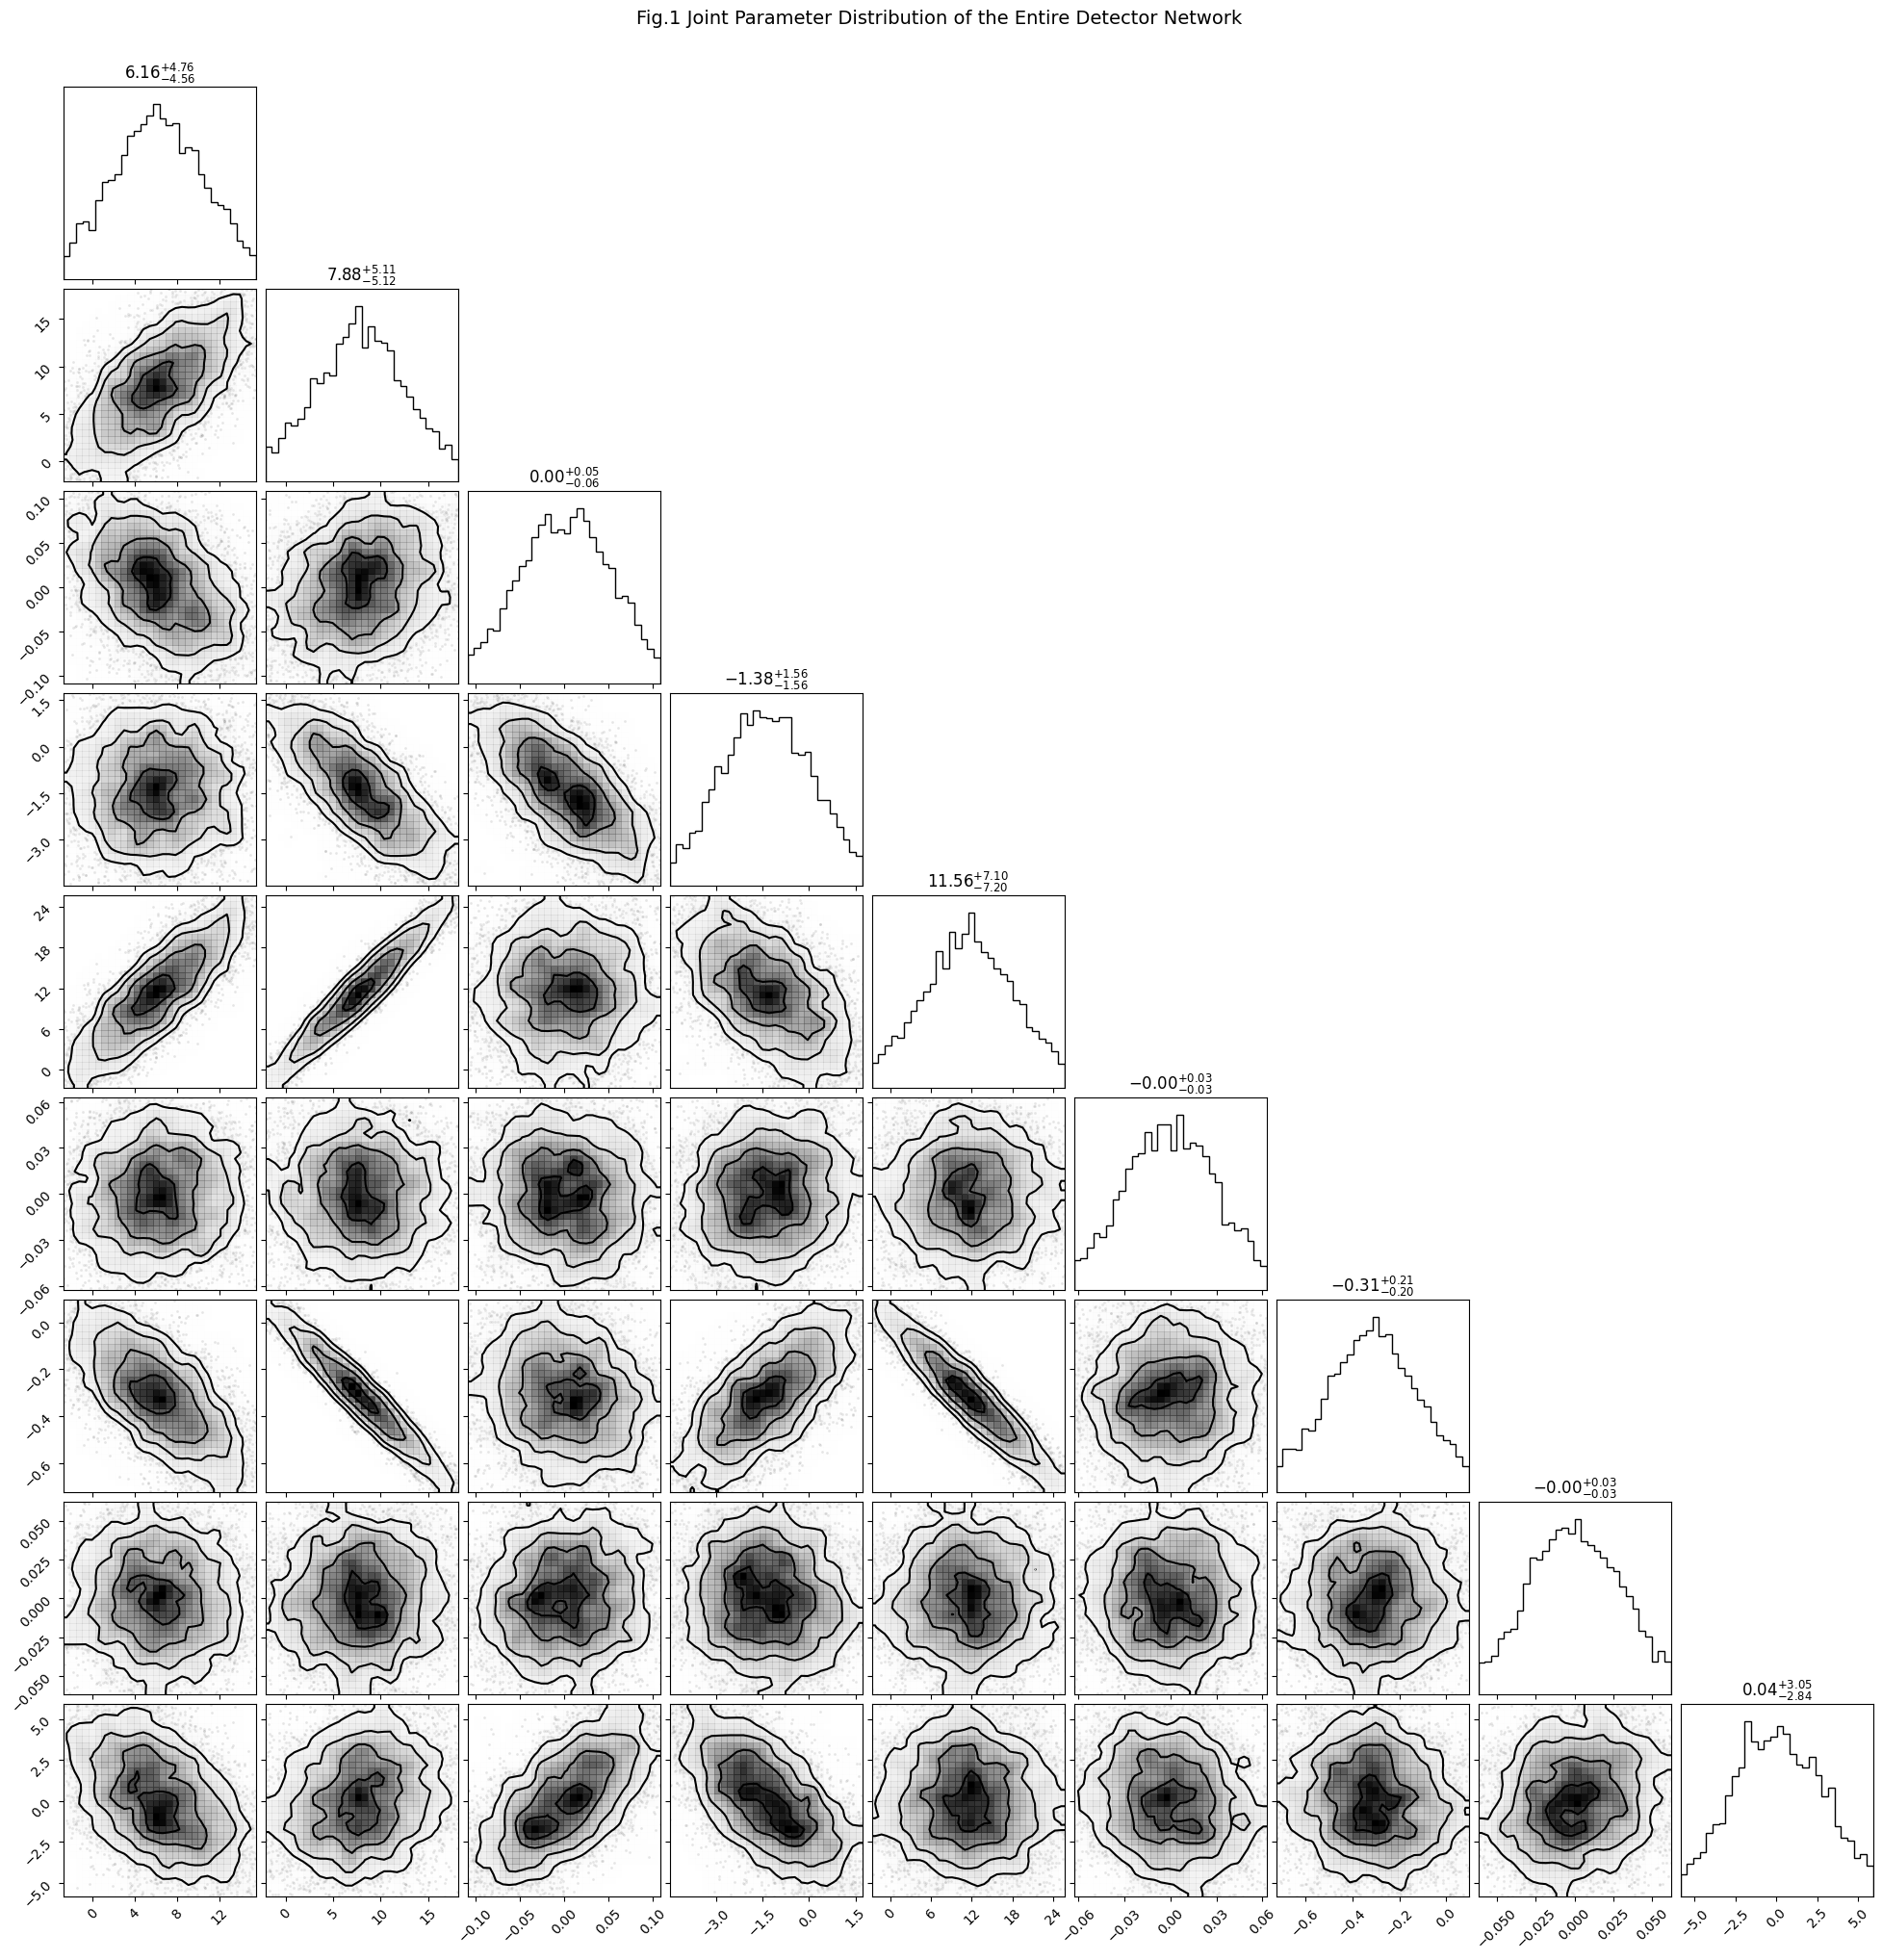

In [6]:
# 从每个探测器的协方差矩阵生成真实的样本点
samples_1 = np.random.multivariate_normal(mean1, cov_matrix_1, size=50000)
samples_2 = np.random.multivariate_normal(mean2, cov_matrix_2, size=50000)
samples_3 = np.random.multivariate_normal(mean3, cov_matrix_3, size=50000)

# 合并所有样本用于绘制
samples = np.vstack([samples_1, samples_2, samples_3])
samples = samples[:5000]  # 只使用前5000个样本

# 绘制探测器的参数联合分布图
fig = corner.corner(samples, show_titles=True, title_fmt=".2f",
                    bins=30, smooth=1.0, range=[0.95] * samples.shape[1],
                    plot_density=True)

plt.suptitle("Fig.1 Joint Parameter Distribution of the Entire Detector Network", y=1.02, fontsize=14)
plt.show()
fig.savefig("Fig.1 Joint Parameter Distribution of the Entire Detector Network.png", dpi=300)

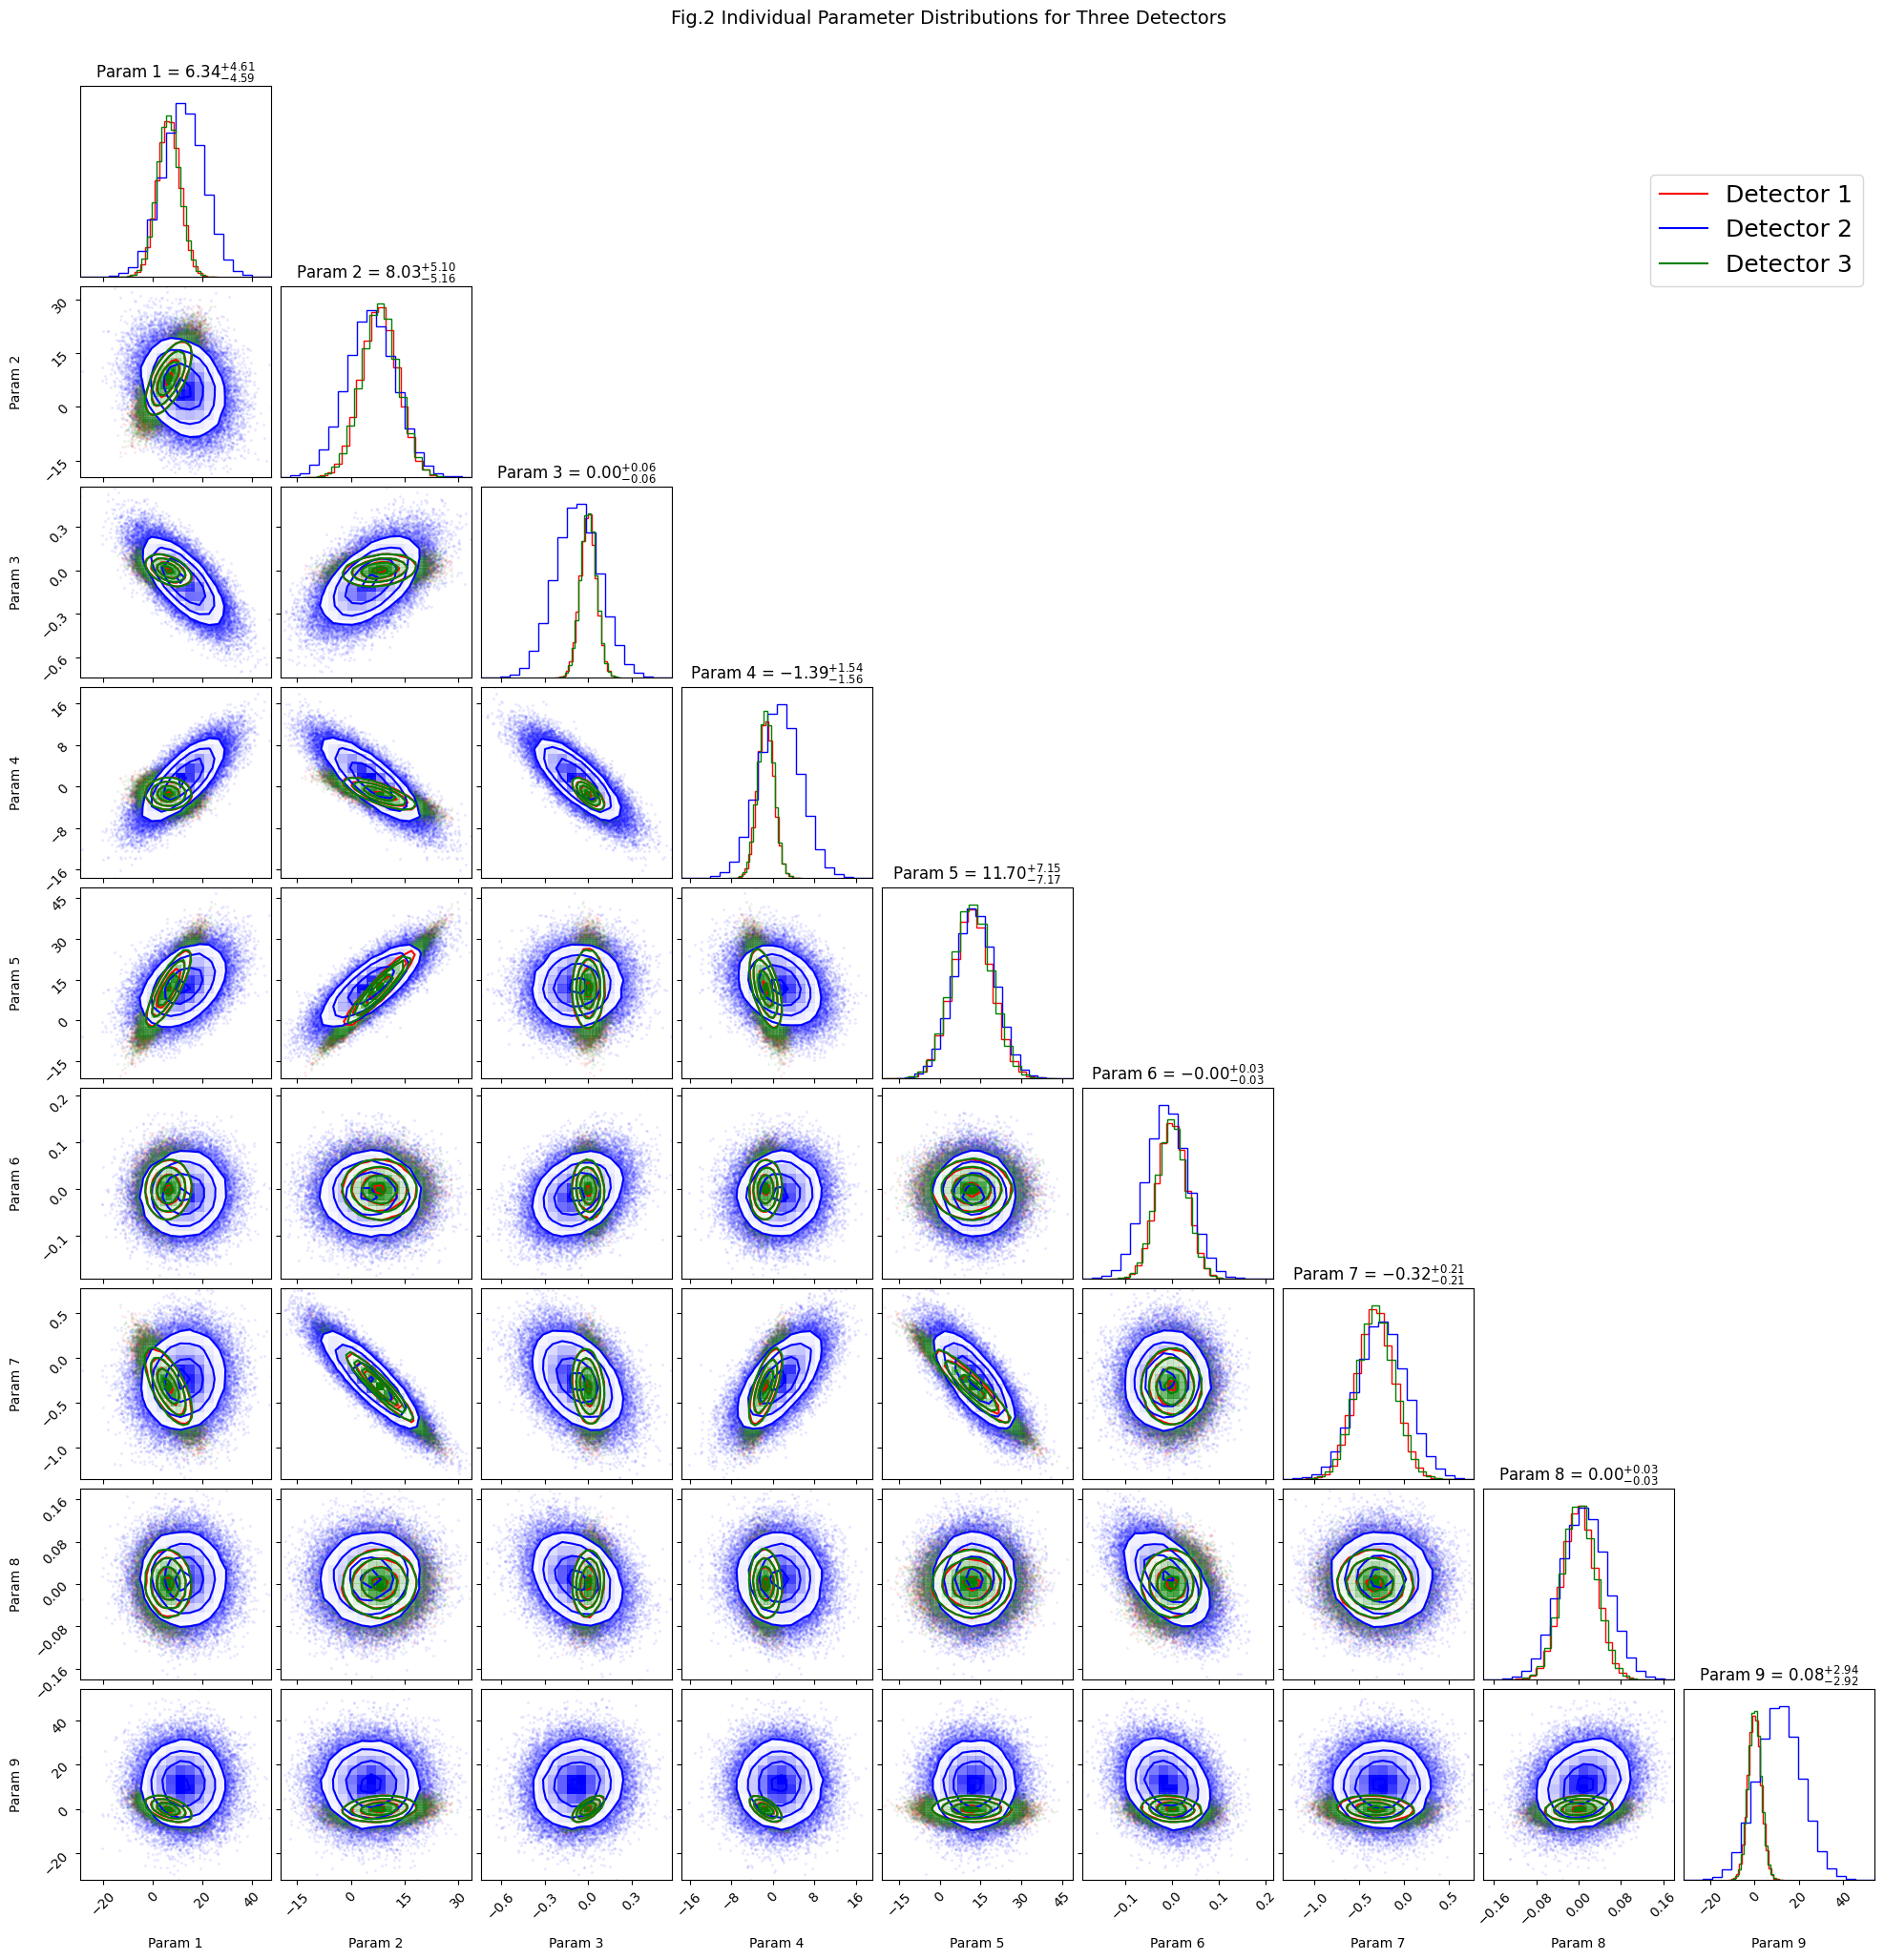

In [7]:
# 创建一个新的figure，绘制探测器1
figure = corner.corner(samples_1, color="red", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
                       show_titles=True, title_fmt=".2f", plot_density=True)

# 绘制探测器2
corner.corner(samples_2, color="blue", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
              show_titles=True, title_fmt=".2f", plot_density=True, fig=figure)

# 绘制探测器3
corner.corner(samples_3, color="green", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
              show_titles=True, title_fmt=".2f", plot_density=True, fig=figure)

# 添加图例，表示颜色对应的探测器
plt.plot([], [], color="red", label="Detector 1")
plt.plot([], [], color="blue", label="Detector 2")
plt.plot([], [], color="green", label="Detector 3")
plt.legend(loc="upper right", bbox_to_anchor=(1, 9), fontsize=18, markerscale=4)

# 添加标题
plt.suptitle("Fig.2 Individual Parameter Distributions for Three Detectors", y=1.02, fontsize=14)

# 显示图像并保存
plt.show()
figure.savefig("Fig.2 Individual Parameter Distributions for Three Detectors.png", dpi=300)

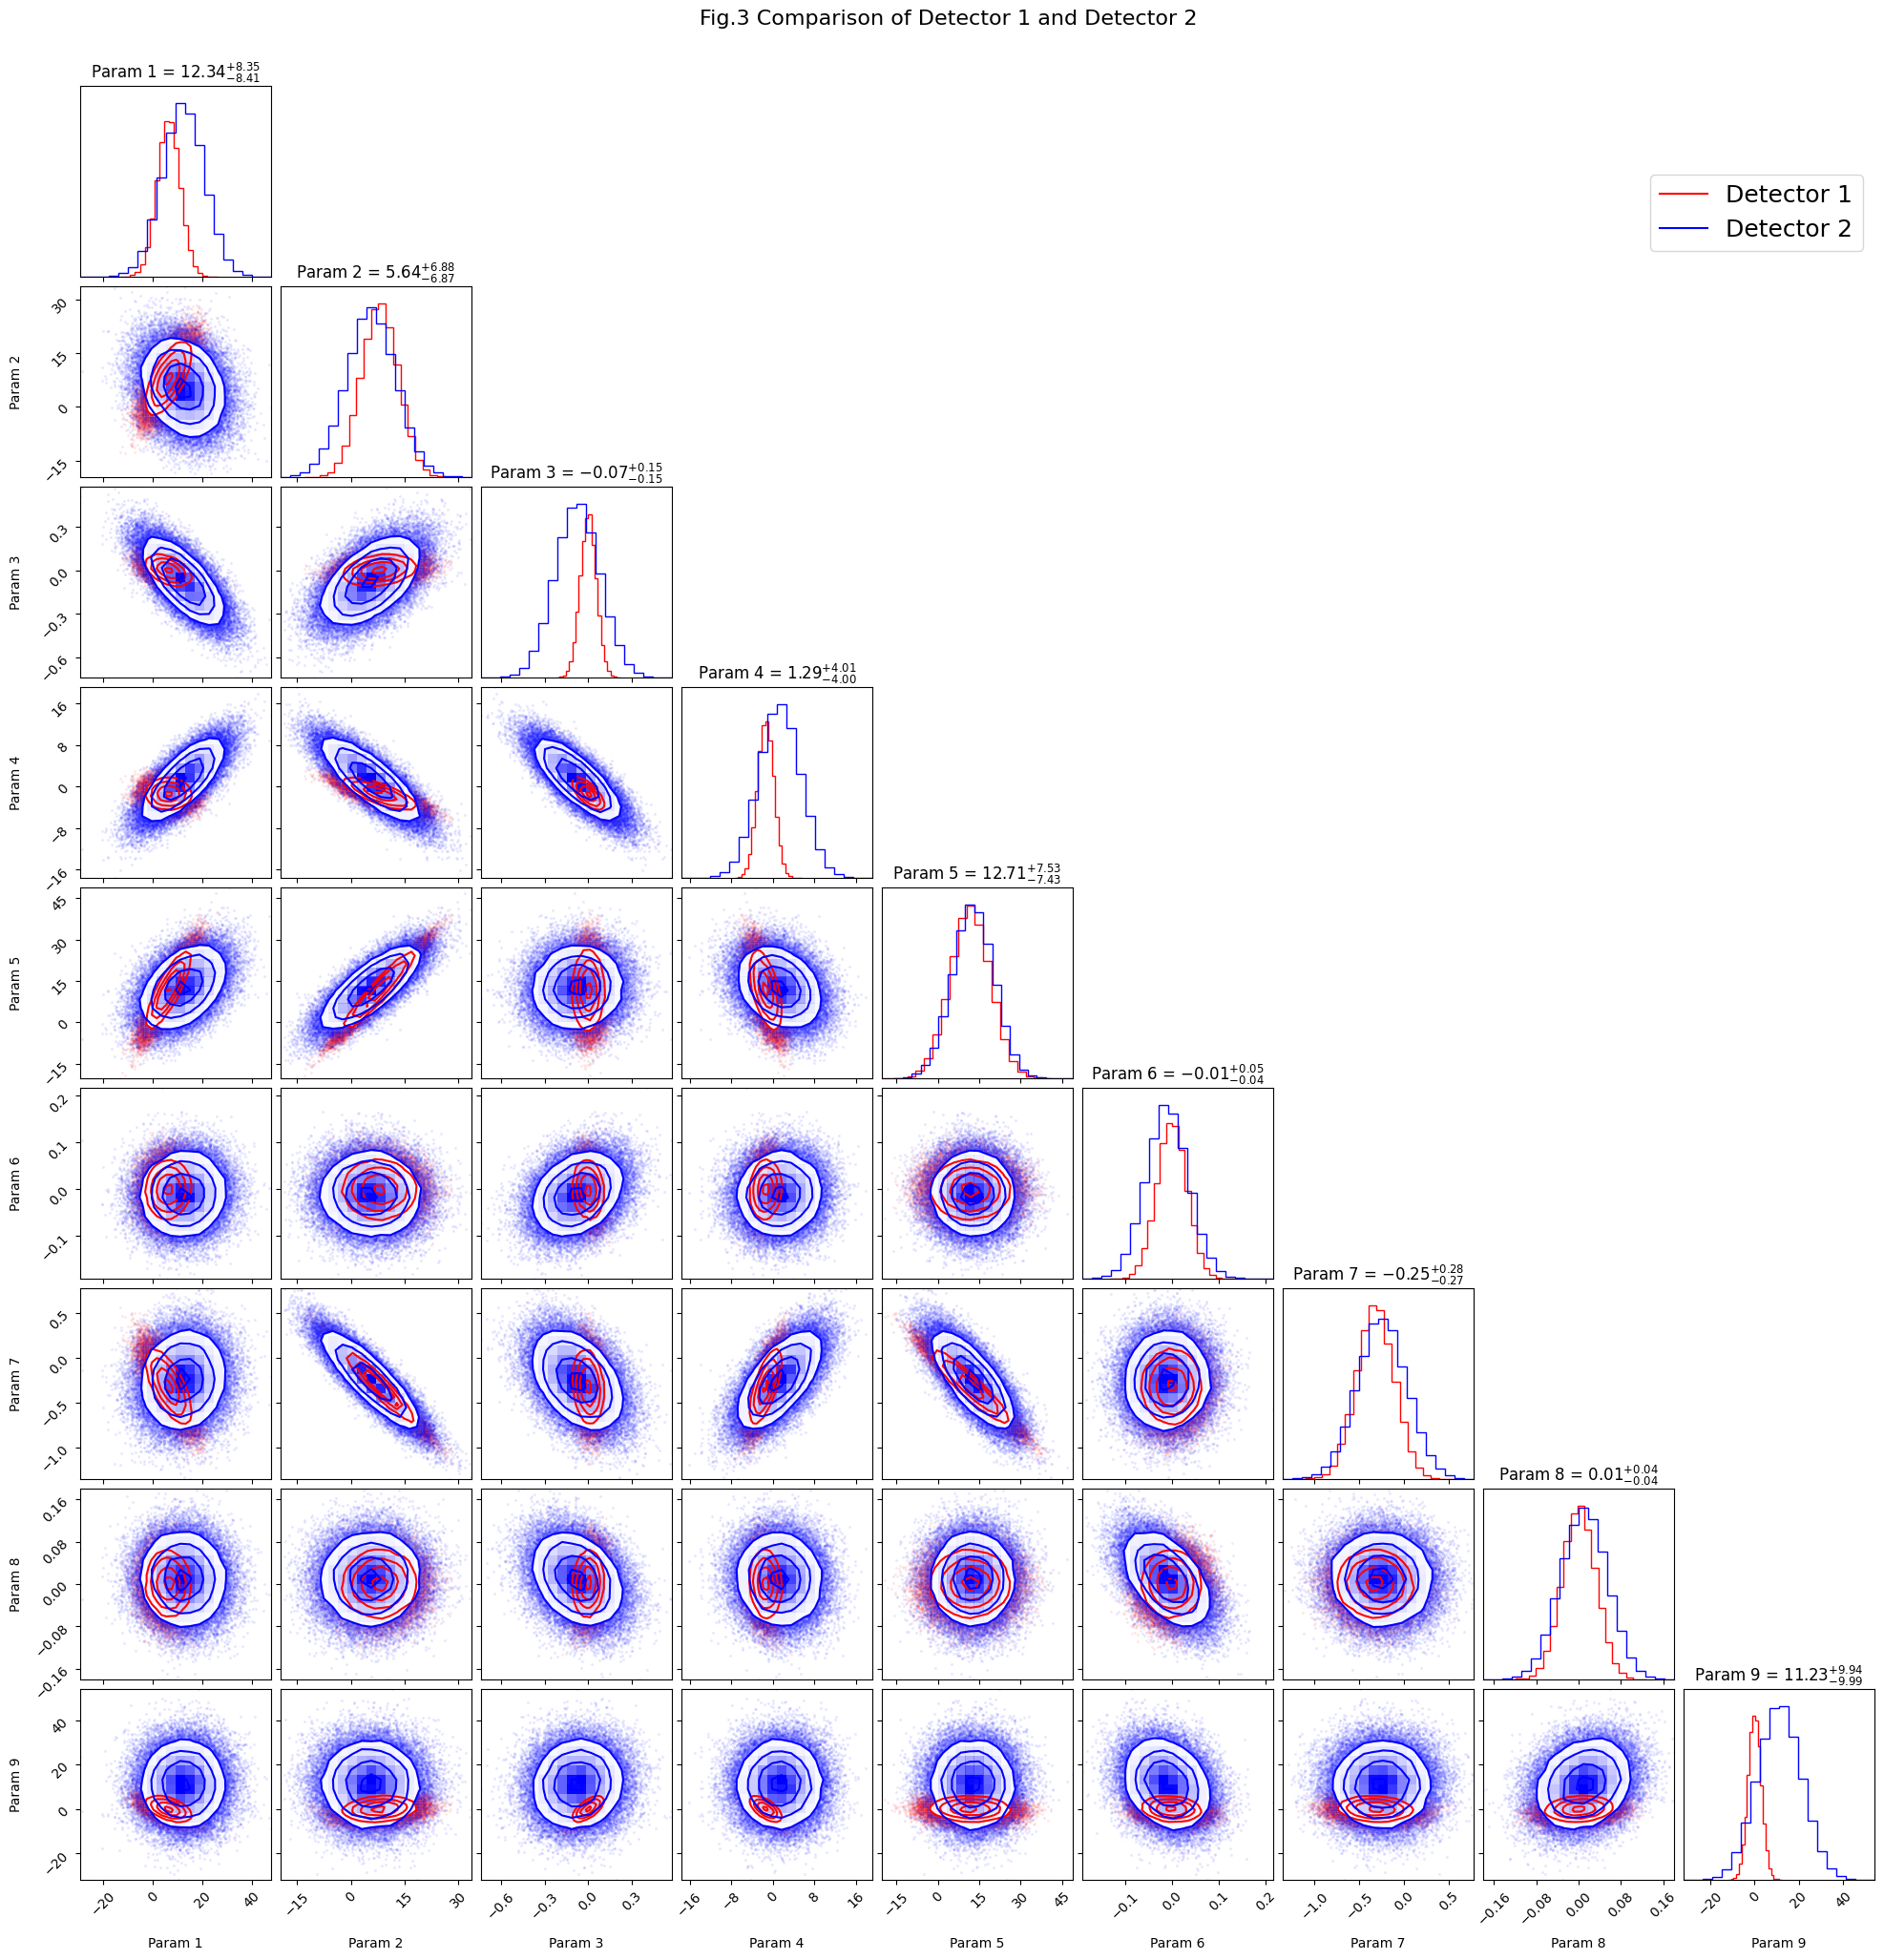

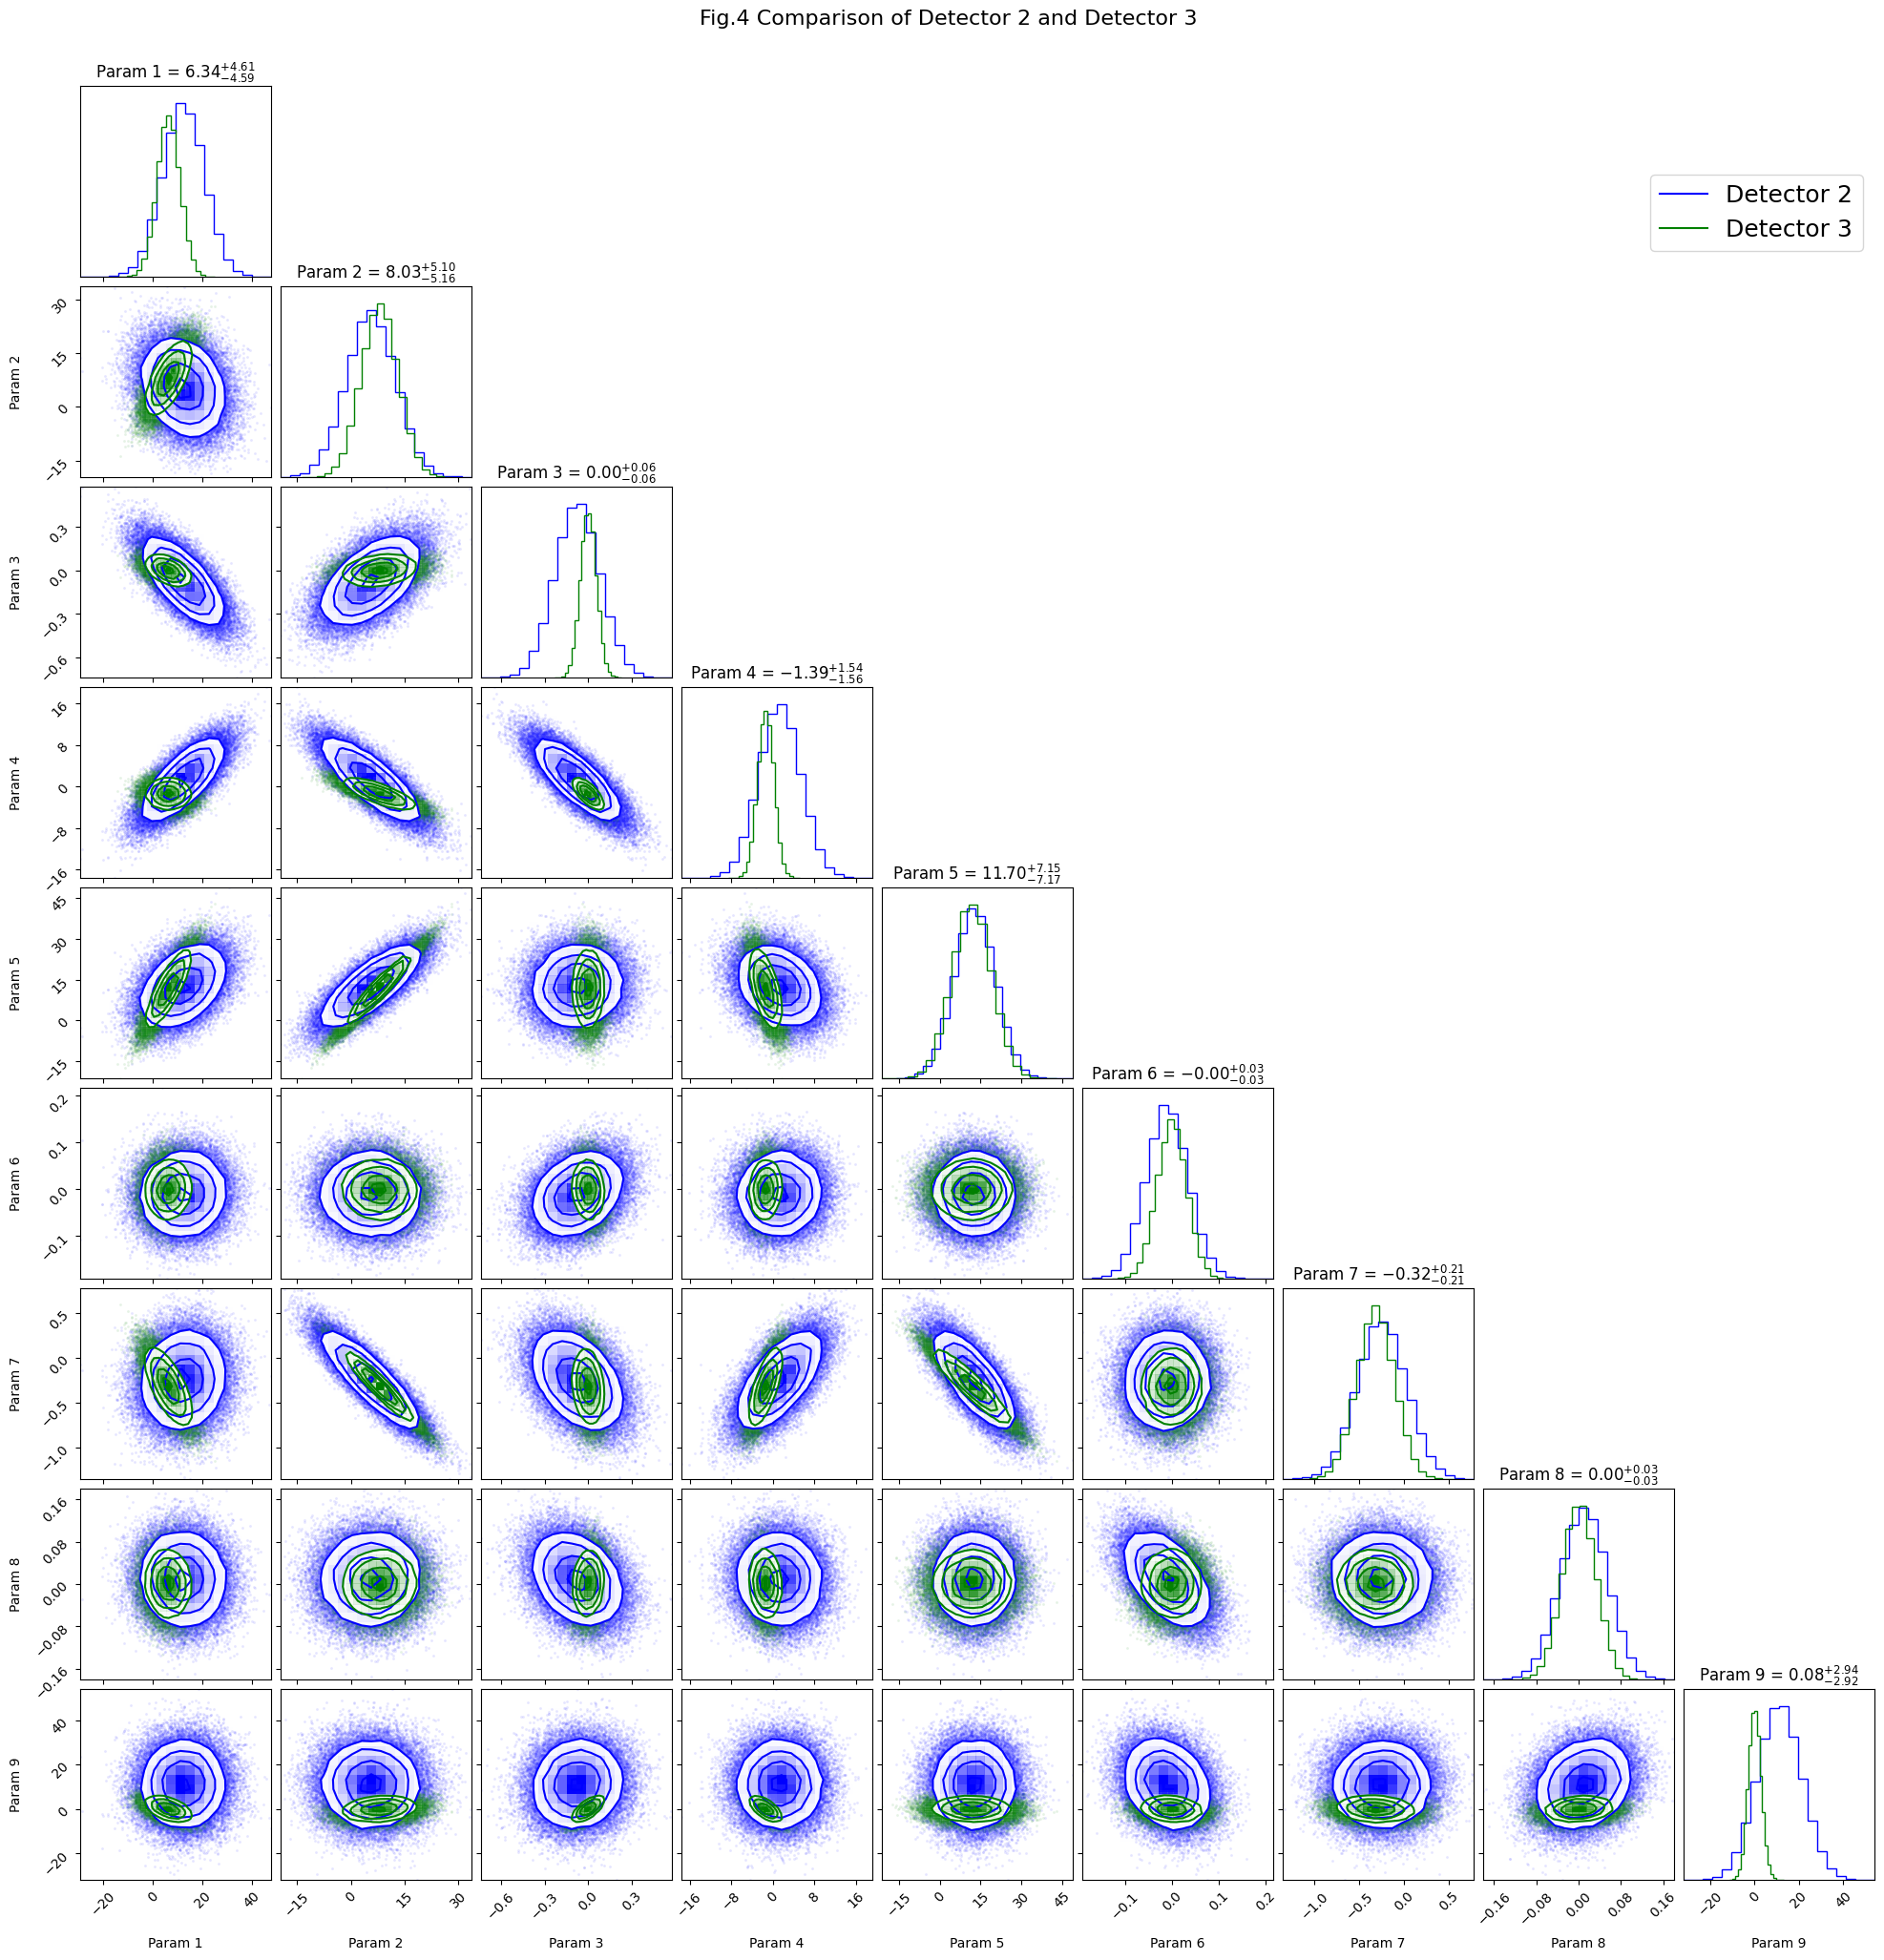

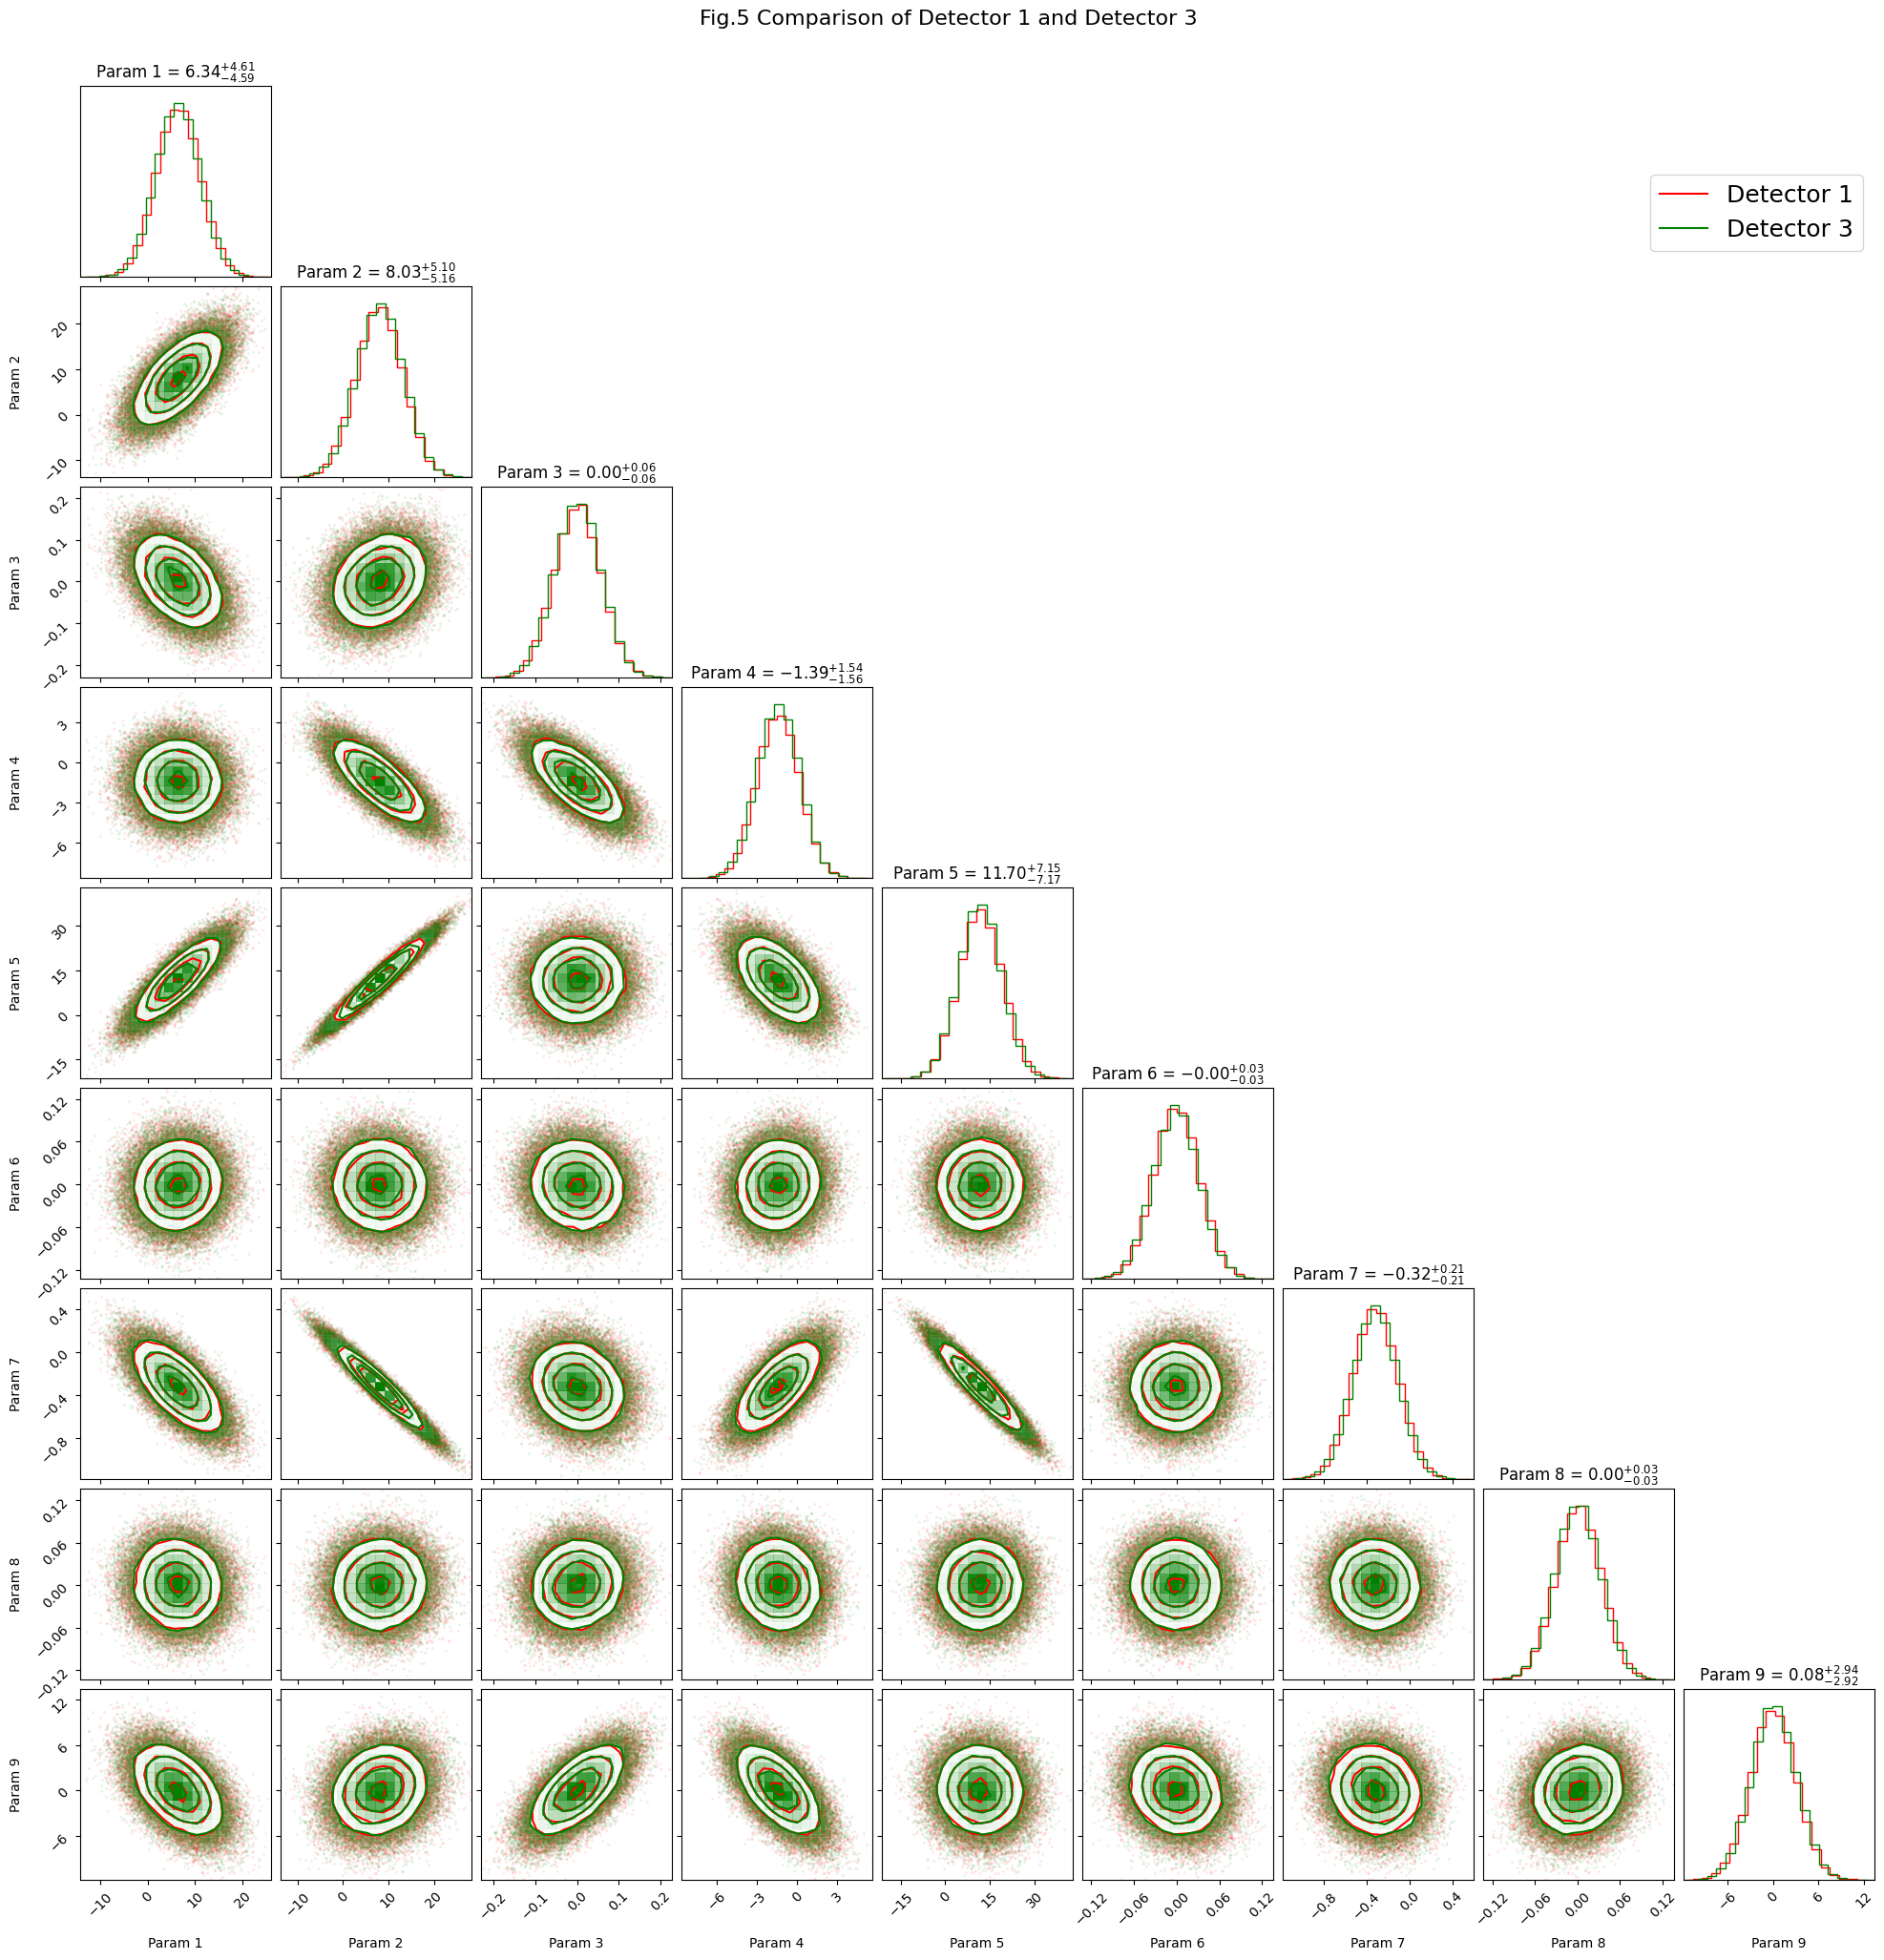

In [8]:
# 比较探测器1和探测器2
figure = corner.corner(samples_1, color="red", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
                       show_titles=True, title_fmt=".2f", plot_density=True)

corner.corner(samples_2, color="blue", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
              show_titles=True, title_fmt=".2f", plot_density=True, fig=figure)

plt.plot([], [], color="red", label="Detector 1")
plt.plot([], [], color="blue", label="Detector 2")
plt.legend(loc="upper right", bbox_to_anchor=(1, 9), fontsize=18, markerscale=4)
plt.suptitle("Fig.3 Comparison of Detector 1 and Detector 2", y=1.02, fontsize=16)
plt.show()
figure.savefig("Fig.3 Comparison of Detector 1 and Detector 2.png", dpi=300)


# 比较探测器2和探测器3
figure = corner.corner(samples_2, color="blue", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
                       show_titles=True, title_fmt=".2f", plot_density=True)

corner.corner(samples_3, color="green", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
              show_titles=True, title_fmt=".2f", plot_density=True, fig=figure)

plt.plot([], [], color="blue", label="Detector 2")
plt.plot([], [], color="green", label="Detector 3")
plt.legend(loc="upper right", bbox_to_anchor=(1, 9), fontsize=18, markerscale=4)
plt.suptitle("Fig.4 Comparison of Detector 2 and Detector 3", y=1.02, fontsize=16)
plt.show()
figure.savefig("Fig.4 Comparison of Detector 2 and Detector 3.png", dpi=300)


# 比较探测器1和探测器3
figure = corner.corner(samples_1, color="red", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
                       show_titles=True, title_fmt=".2f", plot_density=True)

corner.corner(samples_3, color="green", labels=["Param 1", "Param 2", "Param 3", "Param 4", "Param 5", "Param 6", "Param 7", "Param 8", "Param 9"],
              show_titles=True, title_fmt=".2f", plot_density=True, fig=figure)

plt.plot([], [], color="red", label="Detector 1")
plt.plot([], [], color="green", label="Detector 3")
plt.legend(loc="upper right", bbox_to_anchor=(1, 9), fontsize=18, markerscale=4)
plt.suptitle("Fig.5 Comparison of Detector 1 and Detector 3", y=1.02, fontsize=16)
plt.show()
figure.savefig("Fig.5 Comparison of Detector 1 and Detector 3.png", dpi=300)

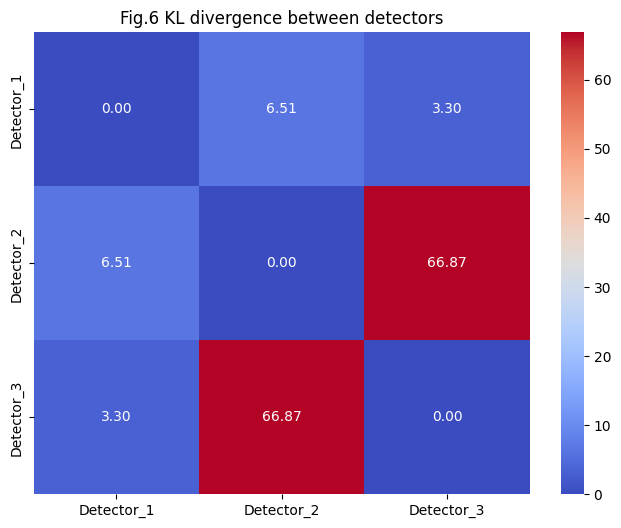

In [9]:
import seaborn as sns

# 创建KL散度矩阵
kl_matrix = np.array([[0, kl_12, kl_13],
                      [kl_12, 0, kl_23],
                      [kl_13, kl_23, 0]])

# 绘制热图
plt.figure(figsize=(8, 6))
sns.heatmap(kl_matrix, annot=True, fmt=".2f", cmap="coolwarm",
            xticklabels=["Detector_1", "Detector_2", "Detector_3"], 
            yticklabels=["Detector_1", "Detector_2", "Detector_3"])
plt.title("Fig.6 KL divergence between detectors")

# 保存图像
plt.savefig("Fig.6 KL divergence between detectors.png", dpi=300)  # 使用 plt.savefig 而不是 fig.savefig
plt.show()

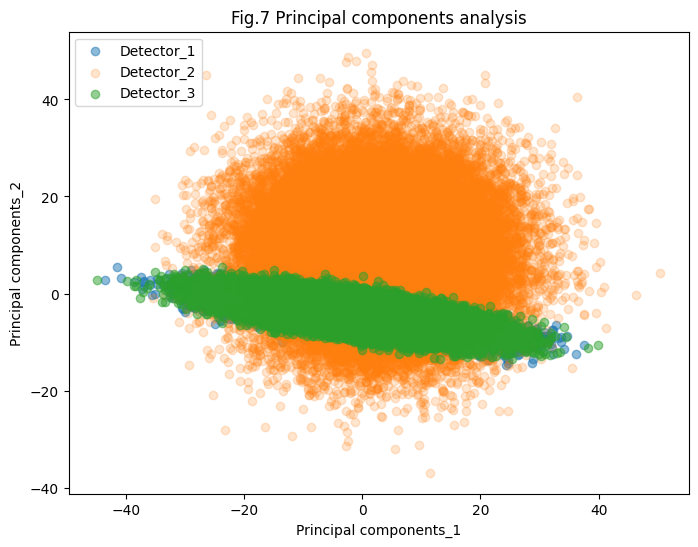

In [10]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# 假设你已经有三个探测器的样本数据
samples = np.vstack([samples_1, samples_2, samples_3])

# PCA降维到2维
pca = PCA(n_components=2)
pca_samples = pca.fit_transform(samples)

# 创建标签来区分不同探测器
labels = np.array([1]*len(samples_1) + [2]*len(samples_2) + [3]*len(samples_3))

# 绘制PCA结果
plt.figure(figsize=(8, 6))  # 创建图形
plt.scatter(pca_samples[labels == 1, 0], pca_samples[labels == 1, 1], label='Detector_1', alpha=0.5)
plt.scatter(pca_samples[labels == 2, 0], pca_samples[labels == 2, 1], label='Detector_2', alpha=0.2)
plt.scatter(pca_samples[labels == 3, 0], pca_samples[labels == 3, 1], label='Detector_3', alpha=0.5)
plt.xlabel('Principal components_1')
plt.ylabel('Principal components_2')
plt.title('Fig.7 Principal components analysis')
plt.legend()

# 保存图像
plt.savefig("Fig.7 Principal_components_analysis.png", dpi=300)  # 保存图像
plt.show()